In [26]:
from scipy.sparse import csgraph
from scipy import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans

from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

In [27]:
# pro_df = pd.read_csv("train_FD004.txt", sep = ' ' ,parse_dates = True , header =None)

In [28]:
df = pd.read_csv("nyc_taxi.csv")

In [29]:
df

timestamp  value
0      2014-07-01 00:00:00  10844
1      2014-07-01 00:30:00   8127
2      2014-07-01 01:00:00   6210
3      2014-07-01 01:30:00   4656
4      2014-07-01 02:00:00   3820
...                    ...    ...
10315  2015-01-31 21:30:00  24670
10316  2015-01-31 22:00:00  25721
10317  2015-01-31 22:30:00  27309
10318  2015-01-31 23:00:00  26591
10319  2015-01-31 23:30:00  26288

[10320 rows x 2 columns]

In [30]:
data = df['value'].values

x= data.reshape(len(data),1)




In [31]:
x.shape

(10320, 1)

In [32]:
def laplace_graph(data,n_neighbors):
    
    data_size = x.shape[0]
    knn_dist_graph = kneighbors_graph(X=x,
                                 n_neighbors=n_neighbors,
                                 mode='distance',
                                 metric='euclidean',
                                 n_jobs=6)
    
    sigma = 1
    similarity_graph = sparse.csr_matrix(knn_dist_graph.shape)
    nonzeroindices = knn_dist_graph.nonzero()
    similarity_graph[nonzeroindices] = np.exp( -np.asarray(knn_dist_graph[nonzeroindices])**2 / 2.0 * sigma**2)
    similarity_graph = 0.5 * (similarity_graph + similarity_graph.T)
    degree_matrix = similarity_graph.sum(axis=1)
    diagonal_matrix = np.diag(np.asarray(degree_matrix).reshape(data_size,))
    L =  diagonal_matrix - similarity_graph
    return L
    
    
    

In [33]:
n = 10
L= laplace_graph(x,n)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [34]:
L.shape

(10320, 10320)

In [35]:
class elm:
    def __init__(self, input_data, nh,lamba2):
        self.input = input_data
        self.hidden_neurons= nh
        self.lambda2 = lamba2
        self.wr = np.random.rand(self.input.shape[1], self.hidden_neurons)
        self.br = np.random.rand(1, self.hidden_neurons)
        
    def sigmoid(self,x):
        return (1 / (1 + np.exp(-x)))
    
    def compute_H(self):
        H_ops = np.matmul(np.transpose(self.wr), np.transpose(self.input)) + np.transpose(self.br)
        H_ops = self.sigmoid(H_ops)
        H_ops = np.transpose(H_ops)
        return H_ops
    
    def w_star(self, H):
        a = np.linalg.inv(np.matmul(np.transpose(H), H) + self.lambda2*np.identity(self.hidden_neurons))
        b = np.matmul(np.transpose(H), self.input)
        Wx = np.matmul(a, b)
        return Wx

    def predict(self):
        wr = self.wr; br = self.br
        H = self.compute_H()
        Wx = self.w_star(H)
        a = np.matmul(np.transpose(wr), np.transpose(self.input))
        b = np.transpose(br); c = self.sigmoid(a + b)
        recons = np.matmul(np.transpose(Wx), c)
        return np.transpose(recons)

In [47]:
nh =1000
lambda2 =5
N= x.shape[0]

In [48]:
N

10320

In [49]:
model = elm(x,nh,lambda2)

In [50]:
H= model.compute_H()

In [51]:
H.shape

(10320, 100)

### eigen values and eigen vectors
"here a is matrix, w is the eigen value "
"v is the eigen vector corresponding to the eigen value in the above order"

a = np.array([[3, 1], [2, 2]])


w, v = np.linalg.eig(a)



In [52]:
Ih = np.identity(nh)
Iu = np.identity(N)
lamda = 2


In [53]:
if nh <= N:
    A= Ih+ lamda* np.matmul(np.transpose(H),np.matmul(L,H))
    B= np.matmul(np.transpose(H),H)
    r,v = np.linalg.eig(A)
    arr1inds = r.argsort()
    v1 = v.copy()
    v2 = v1[arr1inds]
    v3 = v2[:,1:]
    vec1 = np.matmul(H,v)
    vec_norm1 = np.linalg.norm(vec1) 
    vi= v3 /vec_norm1
    W = vi
    print('weight calculated for nh<=N sample data ...')
    
else:
    
    A= Iu+ lamda* np.matmul(L,np.matmul(H,H.T))
    B= np.matmul(np.transpose(H),H)
    r,u = np.linalg.eig(A)
    arr1inds = r.argsort()
    u1 = u.copy()
    u2= u1[arr1inds]
    u3 = u2[:,1:]
    vec2 =np.matmul(H, np.matmul(H.T,u))
    vec_norm2 = np.linalg.norm(vec2)
    ui= u3/vec_norm2
    W= np.matmul(H.T,u)
    print('weight calculated for sparse sample data ...')

weight calculated for nh<=N sample data ...


In [54]:
"embedding matrix"

E = np.matmul(H,W)

In [55]:
E.shape

(10320, 99)

In [56]:
np.set_printoptions(precision=3)

In [57]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

y_km = km.fit_predict(E[:,5])

In [58]:
y= pd.DataFrame(y_km)

In [59]:
anomaly_index = np.where(y_km==1)

In [60]:
anomaly_index

(array([10086, 10087, 10088]),)

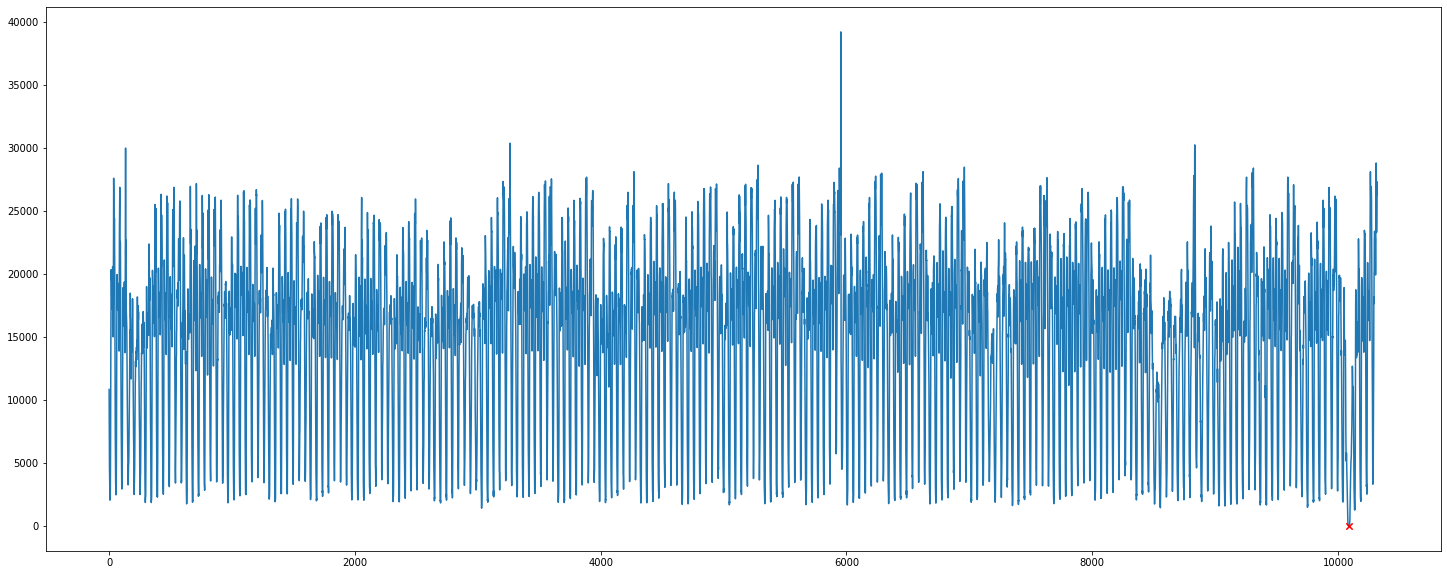

In [61]:
figure = plt.figure(figsize= [25,10])
df_subset = df.iloc[anomaly_index]["value"]
df_data = df.iloc[:,1]
plt.plot(df_data)
plt.plot(df_subset, 'rx')


In [62]:
df_subset = df.iloc[anomaly_index]["value"]

In [63]:
df_subset

10086     8
10087    11
10088     9
Name: value, dtype: int64